In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
#Space Grid:
xmin, xmax = 0,1
N=100
dx = (xmax-xmin)/N
x = np.linspace(xmin,xmax,N)

In [12]:
#Time Grid:
L = 1
D = 1
dt = dx**2 / (2*D)
nt = 200

In [25]:
#Initial Condition:
u = np.zeros(N)
for j in range(N):
    if 0 <= x[j] <= L/2:
        u[j] = 2*x[j] / L
    else:
        u[j] = -2*x[j]/L + 2


In [15]:
def analytic_solution(x, t, M=100, D=1.0, L=1.0):
    u = np.zeros_like(x, dtype=float)
    for m in range(M):
        n = 2*m + 1  # odd terms only
        bn = 8 * ((-1)**m) / (np.pi**2 * n**2)
        u += bn * np.sin(n * np.pi * x / L) * np.exp(-D * (n * np.pi / L)**2 * t)
    return u

In [16]:
#FTCS:
def ftcs(u,dx,dt,N,nt):
    gamma = 2*D * dt / dx**2
    u_new = np.zeros_like(u)
    for n in range(nt):
        for j in range(1,N-1):
            u_new[j]=(1-gamma)*u[j]+ 0.5* gamma* (u[j+1]+u[j-1])
        
        u_new[0] = 0.0
        u_new[N-1] = 0.0
        u[:] = u_new[:]
    return u[:]

In [17]:
t = dt * nt
u_analytic = analytic_solution(x, t, M=100, D=D, L=L)
u_ftcs = ftcs(u,dx,dt,N,nt)

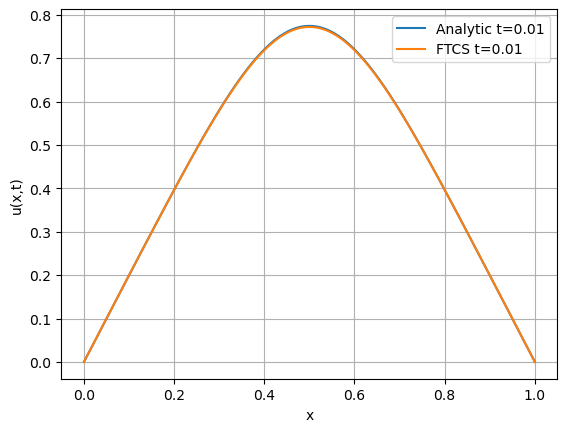

In [18]:
plt.plot(x, u_analytic, label=f'Analytic t={t}')
plt.plot(x, u_ftcs, label=f'FTCS t={t}')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
del u
#Initial Condition:
u = np.zeros(N)
for j in range(N):
    if 0 <= x[j] <= L/2:
        u[j] = 2*x[j] / L
    else:
        u[j] = -2*x[j]/L + 2

In [29]:
#Dufort-Frankel:
def DF(u,dx,dt,N,nt):
    gamma = 2*D * dt / dx**2
    u_old = u.copy()
    u_new = np.zeros_like(u)
    for n in range(nt):
        for j in range(1,N-1):
            u_new[j]=(1-gamma)/(1+gamma)*u_old[j]+ gamma/(1+gamma)* (u[j+1]+u[j-1])
        
        u_new[0] = 0.0
        u_new[N-1] = 0.0
        u_old[:] = u[:]
        u[:] = u_new[:]
    return u[:]

In [30]:
k = 1.0
epsilon = 0.8
dt = k*dx**(1+epsilon)
t = dt * nt
u_analytic = analytic_solution(x, t, M=100, D=D, L=L)
u_DF = DF(u,dx,dt,N,nt)

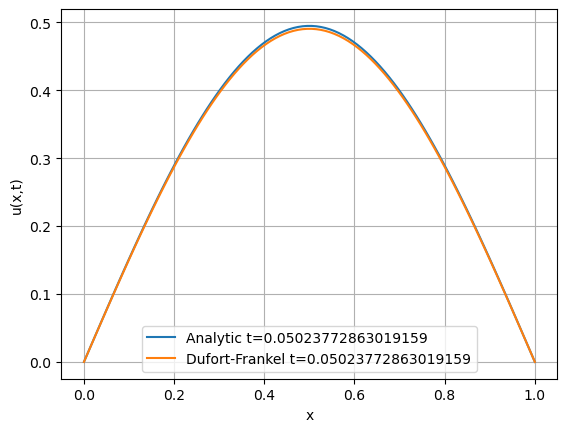

In [31]:
plt.plot(x, u_analytic, label=f'Analytic t={t}')
plt.plot(x, u_DF, label=f'Dufort-Frankel t={t}')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
def thomas_solve(a, b, c, d):
    """
    Solve Ax = d for tridiagonal A given by vectors a, b, c
    (a[0] unused or zero; c[-1] unused or zero). All length m.
    Returns x of length m.
    """
    m = len(d)
    # Copy arrays to avoid modifying inputs
    cp = np.zeros(m)
    dp = np.zeros(m)
    x  = np.zeros(m)
    
    # First row
    if b[0] == 0:
        raise ZeroDivisionError("Zero diagonal in Thomas algorithm")
    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]
    
    # Forward sweep
    for i in range(1, m):
        denom = b[i] - a[i] * cp[i-1]
        if denom == 0:
            raise ZeroDivisionError("Zero pivot encountered in Thomas algorithm")
        cp[i] = c[i] / denom if i < m-1 else 0.0  # last cp not used
        dp[i] = (d[i] - a[i] * dp[i-1]) / denom
    
    # Back substitution
    x[-1] = dp[-1]
    for i in range(m-2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i+1]
    return x

In [34]:
def btcs(u0, dx, dt, D, nt):
    """
    BTCS time-stepping using Thomas algorithm.
    u0: initial array of length N (includes boundary points)
    dx, dt: grid spacing and timestep
    D: diffusion coefficient
    nt: number of time steps
    Returns array u after nt steps (including boundary points).
    Assumes Dirichlet boundaries (u0[0] and u0[-1] fixed).
    """
    u = u0.copy()
    N = len(u)
    gamma = D * dt / dx**2
    
    # unknowns are interior nodes 1..N-2 (m = N-2)
    m = N - 2
    if m <= 0:
        return u
    
    # Build tridiagonal coefficients (length m; index 0 corresponds to node j=1)
    a = np.full(m, -gamma)    # lower diag (a[0] unused conceptually)
    b = np.full(m, 1 + 2*gamma)
    c = np.full(m, -gamma)    # upper diag (c[-1] unused conceptually)
    
    # Time-stepping
    for n in range(nt):
        # Right-hand side: interior u^n
        d = u[1:-1].copy()
        # If boundary values non-zero, add their contribution:
        # For first interior node j=1, the equation has term -gamma * u_0^{n+1}, but u_0 is known
        # move that known piece to RHS as +gamma*u_0. With Dirichlet u_0=0, nothing to add.
        d[0] += gamma * u[0]       # left boundary contribution
        d[-1] += gamma * u[-1]     # right boundary contribution
        
        # Solve A u^{n+1}_interior = d
        u_interior_new = thomas_solve(a, b, c, d)
        
        # Update full u (boundaries unchanged)
        u[1:-1] = u_interior_new
        # u[0], u[-1] stay as Dirichlet BC
    return u

In [35]:
#Initial Condition:
u = np.zeros(N)
for j in range(N):
    if 0 <= x[j] <= L/2:
        u[j] = 2*x[j] / L
    else:
        u[j] = -2*x[j]/L + 2

In [38]:
dt = dx**2 / (2*D)
nt = 200
t = dt * nt
u_analytic = analytic_solution(x, t, M=100, D=D, L=L)
u_btcs = btcs(u,dx,dt,D,nt)

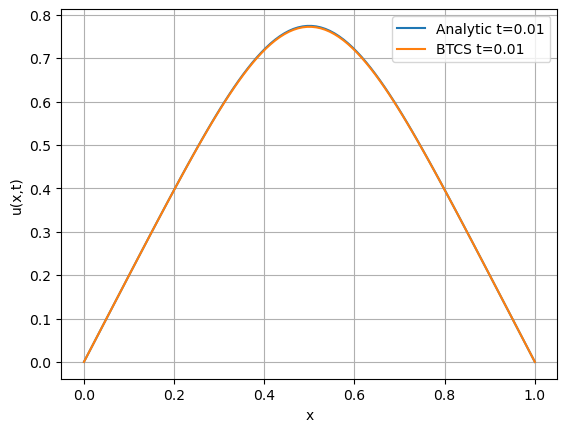

In [41]:
plt.plot(x, u_analytic, label=f'Analytic t={t}')
plt.plot(x, u_btcs, label=f'BTCS t={t}')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend()
plt.grid(True)
plt.show()